In [1]:
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch
!pip install -q pytorch-lightning==1.5.4 matplotlib albumentations

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-xpbllv_d
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-xpbllv_d
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit d7a3eb0e6f55b610c2d41cce53e4c15b8f7d0ea3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 339.1 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 1.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 3.0 MB/s eta 0:00:0000:0100:010m
  Created wheel for segmentation_models_pytorch: filename=segmentation_models_pytorch-0.3.4.dev0-py3-none-any.whl size=109566 sha256=e240b6af5ffa39aba7a59570632d8bdf9795

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

from pprint import pprint
from torch.utils.data import DataLoader

In [2]:
import numpy as np
from torch.utils.data import Dataset
import torch, os, cv2
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
from PIL import Image


class ColorDataSet(Dataset):
    def __init__(self, dataset_path, spatial_augment=False):
        super().__init__()
        self.dataset_path = dataset_path
        self.data_path = os.listdir(self.dataset_path)
        self.spatial_augment = spatial_augment

    def __len__(self):
        return len(self.data_path)

    def __getitem__(self, index):
        # 加载数据
        image_path = os.path.join(self.dataset_path, self.data_path[index], "img.png")
        label_path = os.path.join(self.dataset_path, self.data_path[index], "label.png")

        # image = cv2.imread(image_path)
        # image = Image.fromarray(image)
        image = Image.open(image_path)
        label = Image.open(label_path)

        # 数据增强
        if self.spatial_augment:
            angle = np.random.randint(-10, 11)
            dx = np.random.randint(-10, 11)
            dy = np.random.randint(-10, 11)
            image, label = self.aug_spatial(image, label, angle, dx, dy)

        image = np.array(image)
        image = cv2.resize(image, (320,320))
        image = image.transpose(2, 0, 1)

        label = np.array(label)
        label = cv2.resize(label, (320,320))
        label = ((label > 200) * 255)/255
        label = label[np.newaxis, :, :]

        return {'image':image, 'mask':label}

    def aug_spatial(self, img, label, angle, dx, dy):
        img = F.affine(img, angle=angle, translate=(dx, dy), scale=1.0, shear=0)
        label = F.affine(label, angle=angle, translate=(dx, dy), scale=1.0, shear=0)
        return img, label

In [3]:
data_path = "/home/yyz/视触融合/computer/segment_model/dataset_purple2"
augment = True
batch_size = 4
num_workers = os.cpu_count()

train_dataset = ColorDataSet(data_path+"/train", augment)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valid_dataset = ColorDataSet(data_path+"/val", augment)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

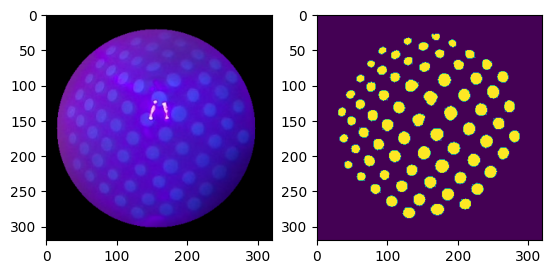

In [4]:
sample = train_dataset[0]

plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

In [5]:
class ColorModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [6]:
# model = ColorModel("Unet", "resnet34", in_channels=3, out_classes=1)

model = ColorModel("FPN", "resnet50", in_channels=3, out_classes=1)

In [7]:
trainer = pl.Trainer(
    gpus=1, 
    max_epochs=10,
    log_every_n_steps=5,
)
trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=valid_dataloader,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | FPN      | 26.1 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
26.1 M    Trainable params
0         Non-trainable params
26.1 M    Total params
104.464   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [51]:
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
pprint(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

[{'valid_dataset_iou': 0.9261463284492493,
  'valid_per_image_iou': 0.926056444644928}]


In [8]:
# After training your model, save it to a directory
# smp_model = model.model
# torch.save(smp_model, './Unet_resnet502.pth')
# loaded_model = torch.load('./Unet_resnet502.pth')
# print("Loaded model:", loaded_model.__class__.__name__)

smp_model = model.model
torch.save(smp_model, './FPN_resnet50_purple4.pth')
loaded_model = torch.load('./FPN_resnet50_purple4.pth')
print("Loaded model:", loaded_model.__class__.__name__)

Loaded model: FPN


In [118]:
loaded_model = torch.load('./Unet_resnet34.pth')
print("Loaded model:", loaded_model.__class__.__name__)

Loaded model: Unet


In [11]:
print(model.mean)
print(model.std)

tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]])
tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]])


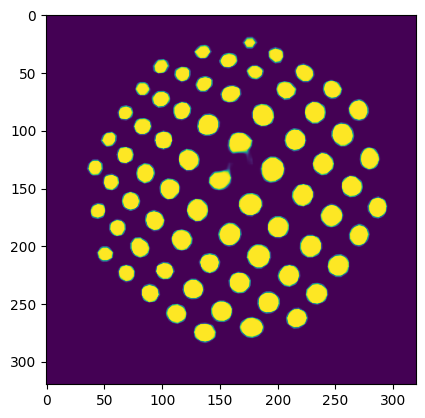

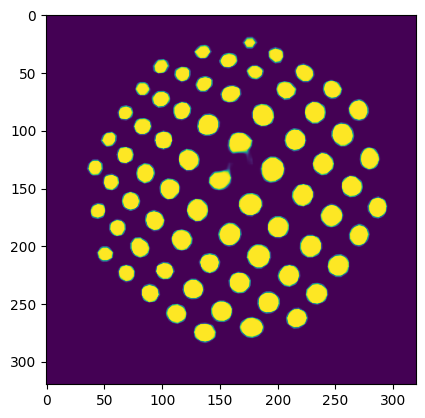

In [9]:
image = train_dataset[0]
image = image['image']
input = torch.FloatTensor(image).unsqueeze(0)
output = loaded_model.predict(input).sigmoid()
with torch.no_grad():
    model.eval()
    output2 = model(input).sigmoid()
    output = loaded_model.predict((input - model.mean) / model.std).sigmoid()

output = output.numpy().squeeze()
plt.imshow(output)
plt.show()
output2 = output2.numpy().squeeze()
plt.imshow(output2)
plt.show()

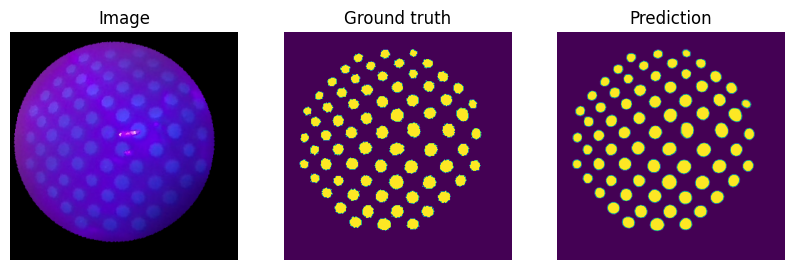

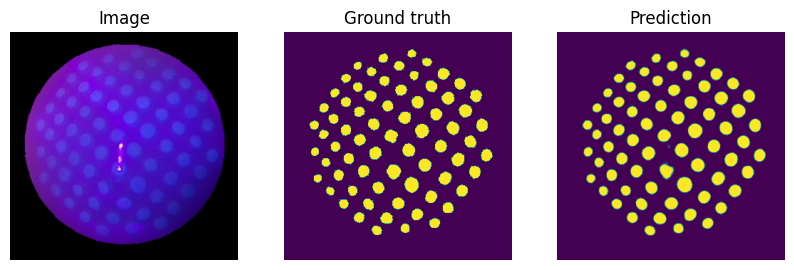

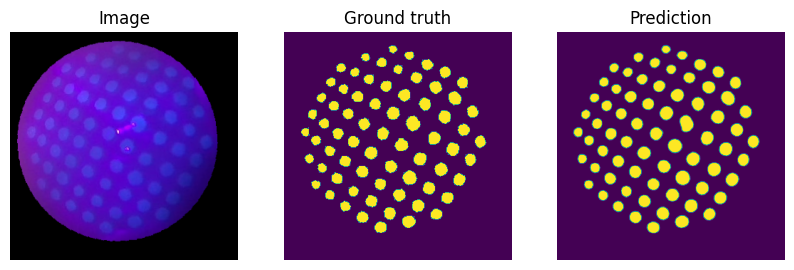

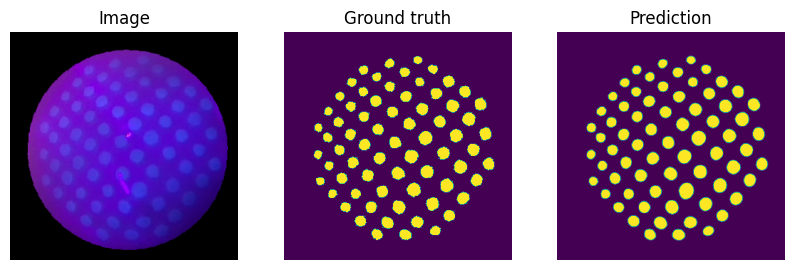

In [10]:
batch = next(iter(train_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()